## Detect Volkswagen

## Objective: create a model that recognize a Volkswagen car, using mainly the FastAI library.


In [1]:
!pip install fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 6.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.28.2
    Uninstalling requests-2.28.2:
      Successfully uninstalled requests-2.28.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.1.2 requires requests<2.29,>=2.24.0, but you have requests 2.29.0 which is incompatible.
librosa 0.10.0.post2 requires soundfile>=0.12.1, but you have soundfile 0.11.0 which is incompatible.
kfp 1.8.20 requires google-api-python-client<2,>=1.7.8, but you have google-api-python-client 2.86.0 which is incompatible.
kfp 1.8.20 requires PyYAML<6,>=5.3, but you have pyyaml 6.0 which is incompatible.
gcsfs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2023.4.0 which is incomp

## Step 1: Download images of drunk person and non-drunk person

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [3]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('black volkswagen car', max_images=1)
urls[0]

Searching for 'black volkswagen car'


'https://www.hdwallpapers.in/download/black_volkswagen_golf_gtd_2020_4k_5k_hd_cars-HD.jpg'

...and then download a URL and take a look at it:

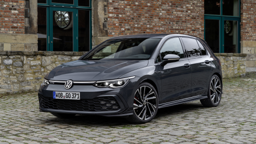

In [13]:
from fastdownload import download_url
dest = 'volkswagen.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'car'


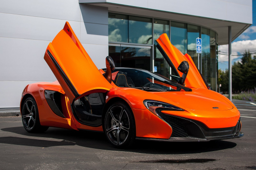

In [5]:
download_url(search_images('car', max_images=1)[0], 'car.jpg', show_progress=False)
Image.open('car.jpg').to_thumb(256,256)

In [6]:
searches = 'car','volkswagen car'
path = Path('volkswagen_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'car photo'
Searching for 'car sun photo'
Searching for 'car shade photo'
Searching for 'volkswagen car photo'
Searching for 'volkswagen car sun photo'
Searching for 'volkswagen car shade photo'


/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

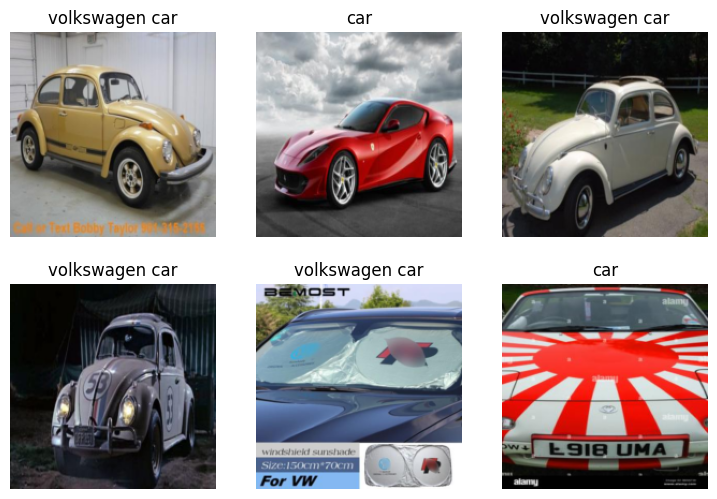

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [9]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 267MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.279767,0.889101,0.352941,00:28


epoch,train_loss,valid_loss,error_rate,time
0,0.820881,0.520190,0.323529,00:37
1,0.509804,0.378685,0.176471,00:26
2,0.365343,0.355303,0.147059,00:28


## Step 3: Use our model

This is a: volkswagen car.
Probability it's a volkswagen car: 0.9698


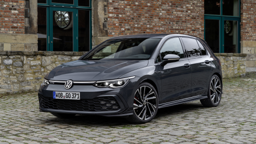

In [14]:
is_bird,_,probs = learn.predict(PILImage.create(dest))
print(f"This is a: {is_bird}.")
print(f"Probability it's a volkswagen car: { 1 - probs[0]:.4f}")

im.to_thumb(256,256)

## See what vocabs our model offer

In [15]:
categories = learn.dls.vocab
categories

['car', 'volkswagen car']

## What is inside of our model?

# Step 4: Export our model

In [16]:
learn.export('model.pkl')

## Ok, but what is this "model.pkl" file?

It is basically a learner that you get after training your model.

But the learner has mainly two things on it:

- First: is the list of pre-processing steps that you did to turn your images into the model, basicaly your data.
- Second: is the trained model itself!

### Also, we can see how is the architecture of the model

In [34]:
model = learn.model
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

# Deploy
Link: https://huggingface.co/spaces/BrunoHenrique00/lesson3